In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from pymer4.models import Lmer
from rpy2.robjects import conversion, default_converter
from sklearn import linear_model
import statsmodels.api as sm

## Очистка

In [2]:
res = []
with open('results.csv') as results:
    for l in results.readlines():
        if 'judgement' in l:
            res.append(l)

In [3]:
with open('results_cleaned.csv', 'w') as f:
    f.write('time,ip,controller,order,inner,label,square,pennelement_type,pennelement_name,parameter,value,event_time,id,text,mod,lin,syn,dupl,comments\n')
    for l in res:
        f.write(l)

## Предобработка

In [4]:
data = pd.read_csv('results_cleaned.csv')

In [5]:
data = data[['time', 'text', 'mod', 'lin', 'syn', 'dupl', 'value']]

In [6]:
data

,time,text,mod,lin,syn,dupl,value
0,1734465754,У меня самого сейчас возникли вопросы к органи...,sam,R,high,False,7
1,1734465754,У всех у нас сегодня очень интересные доклады.,vse,L,high,True,7
2,1734465754,Я каждый раз прошу у него помощи уставшего.,depic,E,low,False,1
3,1734465754,У нас у всех сегодня очень интересные доклады.,vse,R,high,True,7
4,1734465754,И у больного него часто получается лучше%2C че...,depic,L,high,False,1
...,...,...,...,...,...,...,...
1435,1735050392,Не волнуйся%2C он у нас это спрашивал каждого.,kazhdy,E,low,False,1
1436,1735050392,У нас недавно у всех произошло трагическое соб...,vse,E,high,True,7
1437,1735050392,У тебя и пьяного иногда отлично голова работает.,depic,R,high,False,7
1438,1735050392,Мы у них уже бывали в гостях всех.,vse,E,low,False,2


In [7]:
data_num = data.copy()
for col in ['lin', 'syn', 'dupl', 'time']:
    data_num[col] = data[col].astype('category').cat.codes

In [8]:
data_num

,time,text,mod,lin,syn,dupl,value
0,0,У меня самого сейчас возникли вопросы к органи...,sam,2,0,0,7
1,0,У всех у нас сегодня очень интересные доклады.,vse,1,0,1,7
2,0,Я каждый раз прошу у него помощи уставшего.,depic,0,1,0,1
3,0,У нас у всех сегодня очень интересные доклады.,vse,2,0,1,7
4,0,И у больного него часто получается лучше%2C че...,depic,1,0,0,1
...,...,...,...,...,...,...,...
1435,35,Не волнуйся%2C он у нас это спрашивал каждого.,kazhdy,0,1,0,1
1436,35,У нас недавно у всех произошло трагическое соб...,vse,0,0,1,7
1437,35,У тебя и пьяного иногда отлично голова работает.,depic,2,0,0,7
1438,35,Мы у них уже бывали в гостях всех.,vse,0,1,0,2


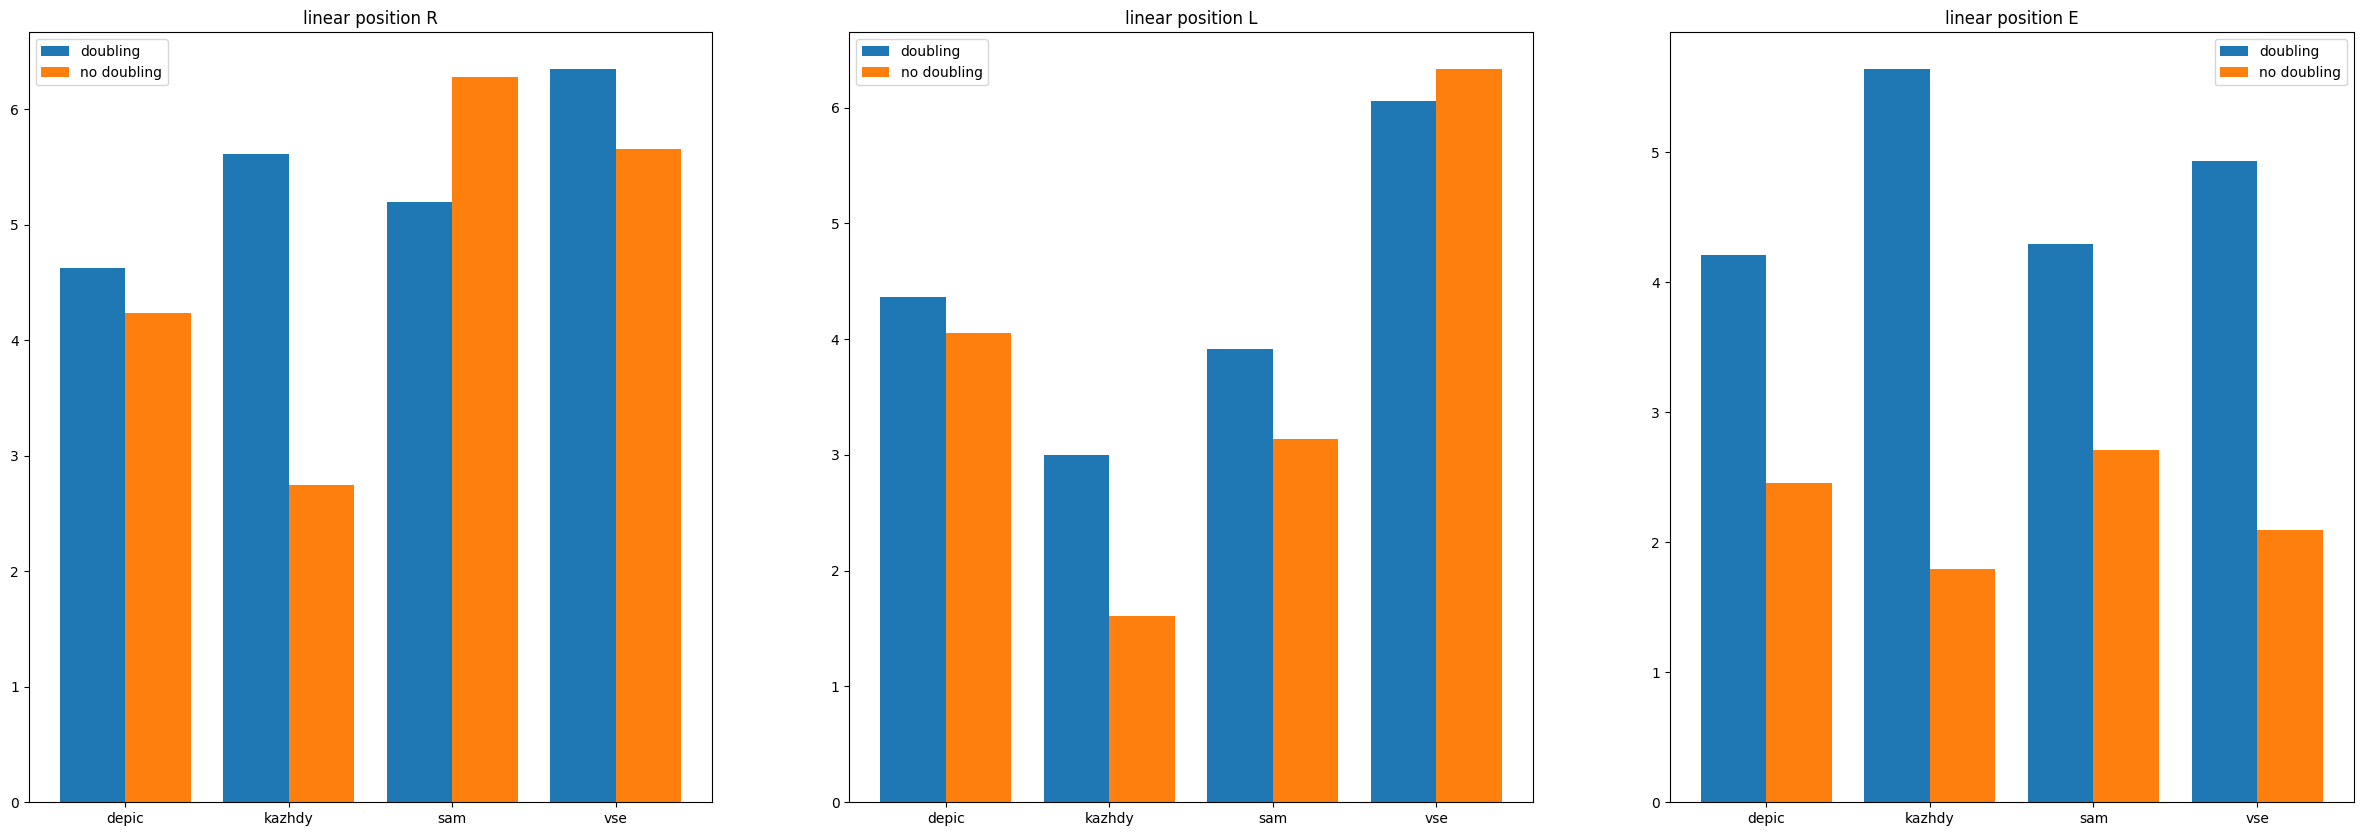

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(30, 10))
for ax, lin in zip(axes.flatten(), data['lin'].unique()):
    data_r = data[data['lin'] == lin].groupby(['mod', 'lin', 'dupl'])['value'].mean().reset_index()
    bars = data_r['mod'].unique()
    x = np.arange(len(bars))
    width = 0.4

    ax.bar(x - 0.2, data_r[ data_r['dupl']]['value'], align='center', width=width)
    ax.bar(x + 0.2, data_r[~data_r['dupl']]['value'], align='center', width=width)
    ax.set_title(f'linear position {lin}')
    ax.set_xticks(x, bars)
    ax.legend(['doubling', 'no doubling'])

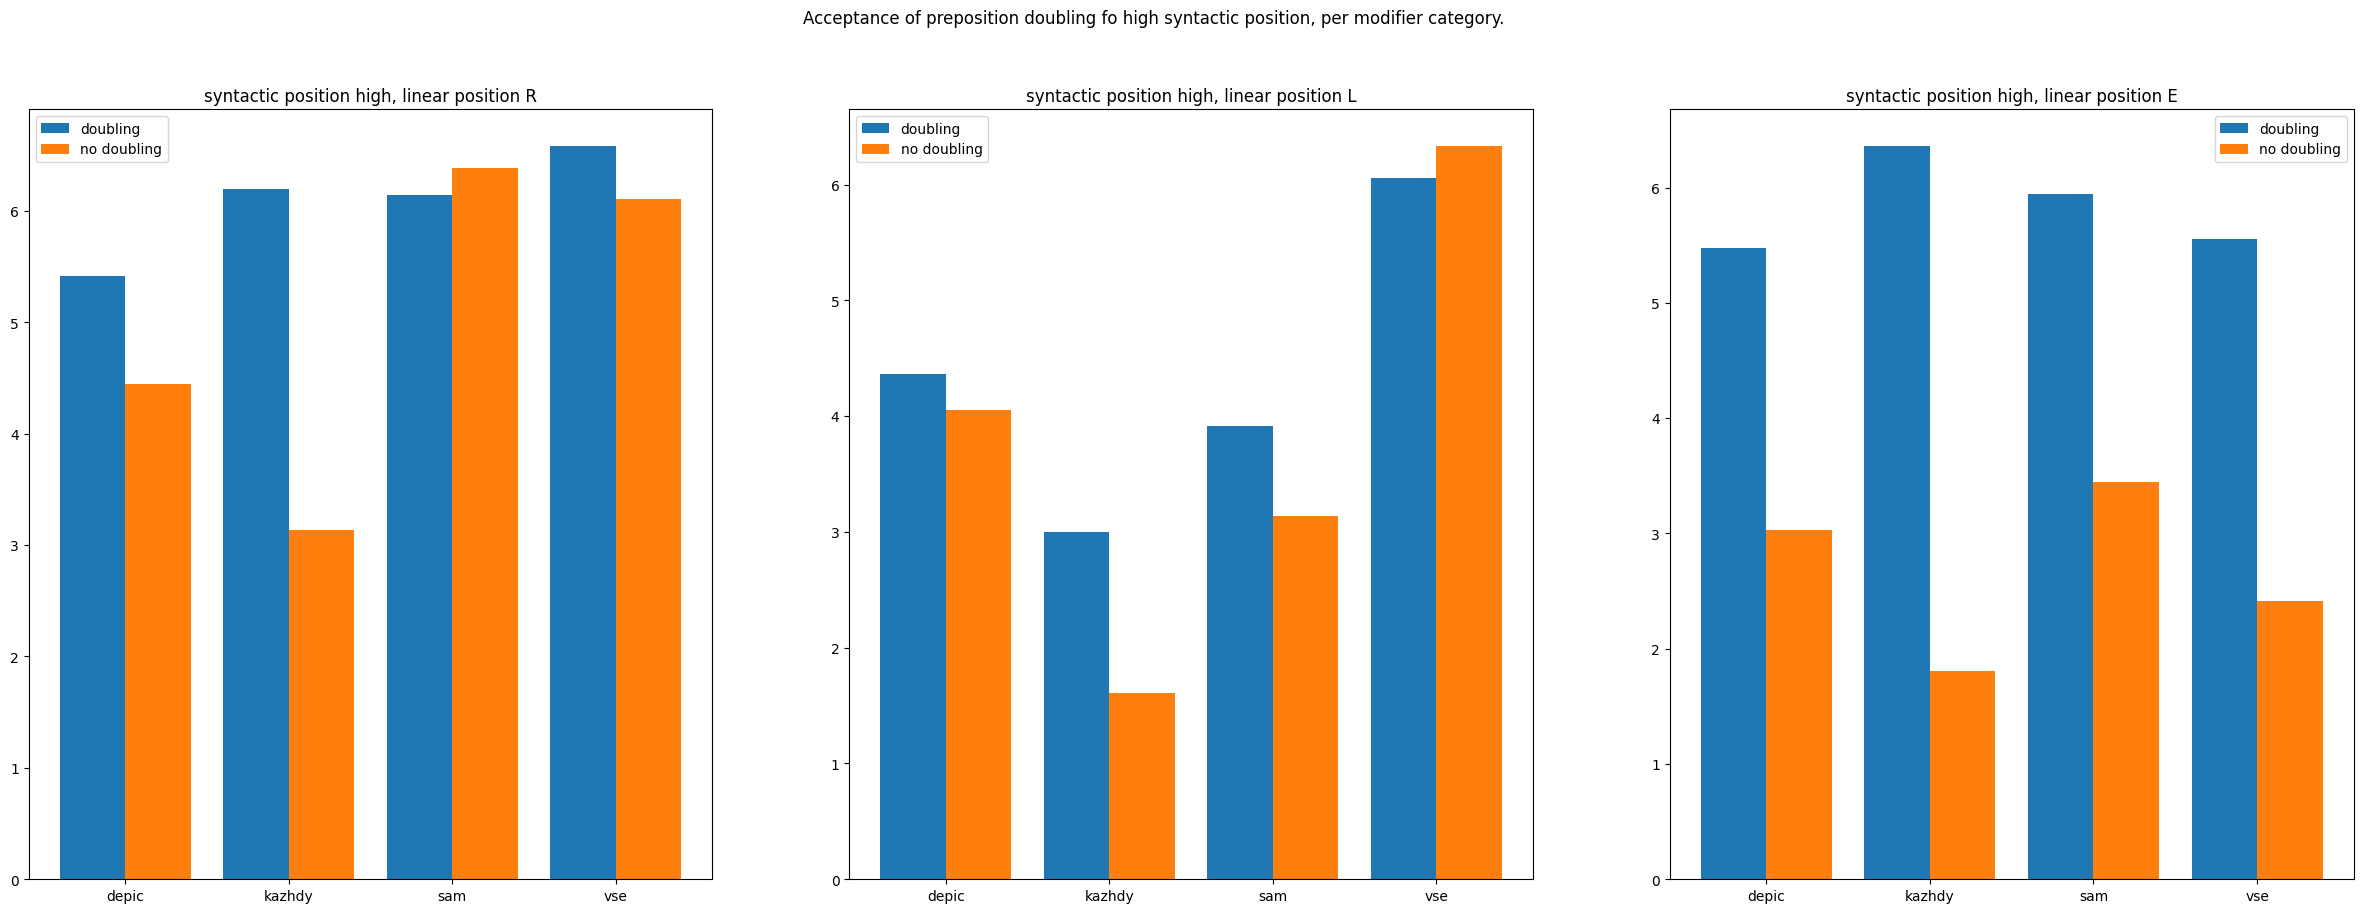

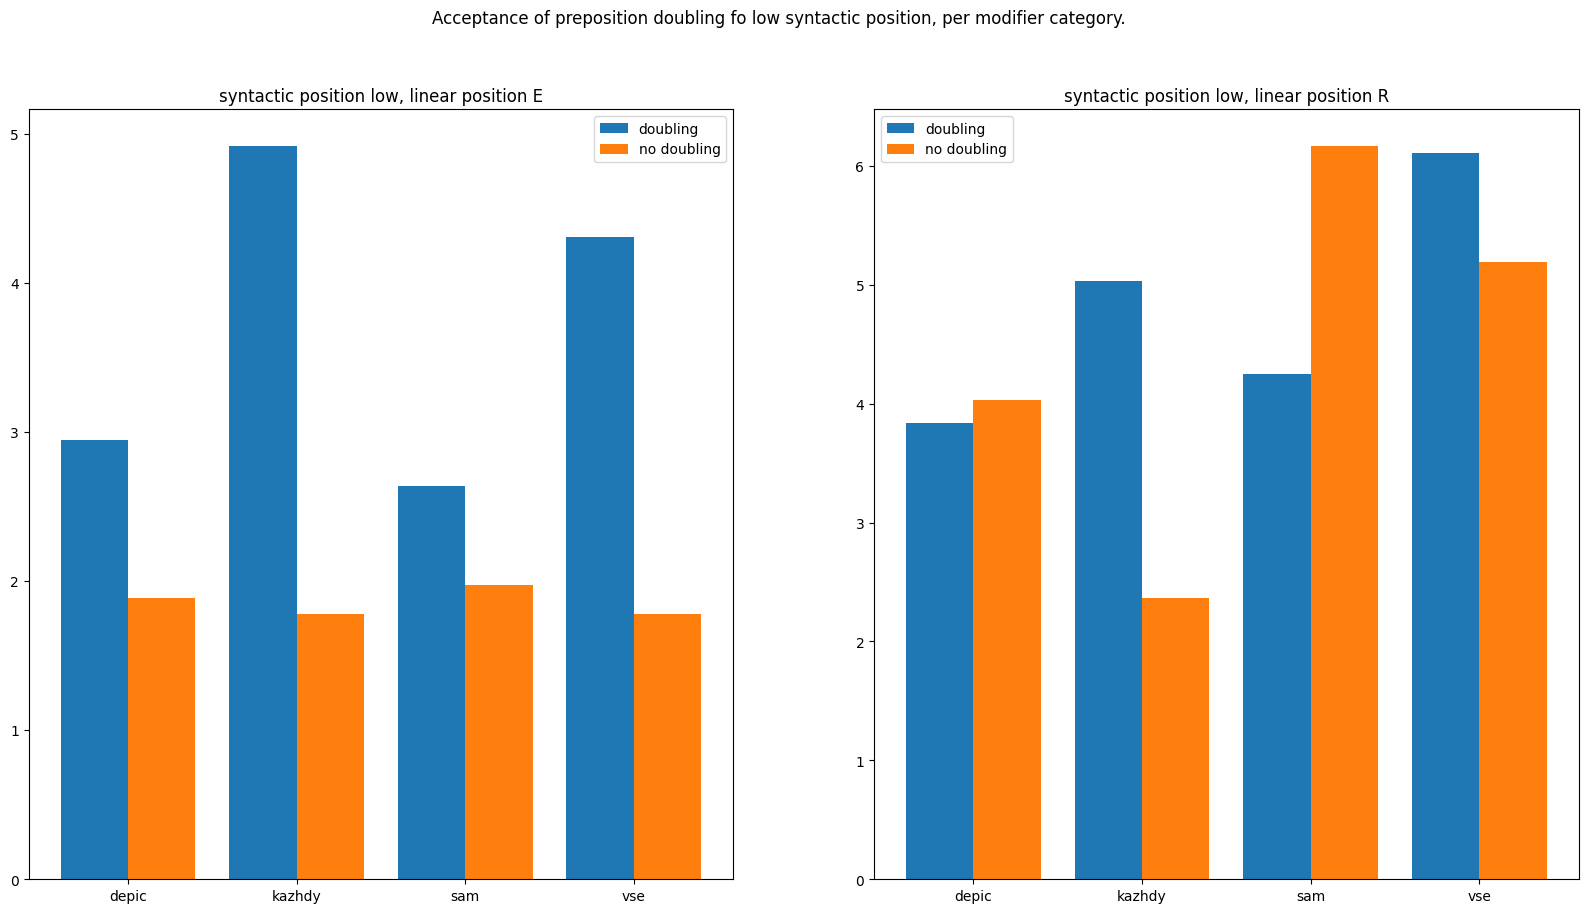

In [15]:

for syn in data['syn'].unique():
    lins = data[data['syn'] == syn]['lin'].unique()
    fig, axes = plt.subplots(1, len(lins), figsize=(len(lins) * 10, 10))
    fig.suptitle(f'Acceptance of preposition doubling fo {syn} syntactic position, per modifier category.')
    for ax, lin in zip(axes.flatten(), lins):
        data_r = data[(data['lin'] == lin) & (data['syn'] == syn)].groupby(['mod', 'lin', 'syn', 'dupl'])['value'].mean().reset_index()
        bars = data_r['mod'].unique()
        x = np.arange(len(bars))
        width = 0.4

        ax.bar(x - 0.2, data_r[ data_r['dupl']]['value'], align='center', width=width)
        ax.bar(x + 0.2, data_r[~data_r['dupl']]['value'], align='center', width=width)
        ax.set_title(f'syntactic position {syn}, linear position {lin}')
        ax.set_xticks(x, bars)
        ax.legend(['doubling', 'no doubling'])
    fig.savefig(f'plot_{syn}.png')

### линрег

In [9]:
X = sm.add_constant(data_num[['lin', 'syn', 'dupl']])
est = sm.OLS(data_num['value'], X).fit()
est.pvalues

const    2.538372e-146
lin       5.571369e-36
syn       2.887015e-16
dupl      1.314139e-35
dtype: float64

ладно

In [22]:
def linreg_mod(mod):
    data_mod = data_num[data_num['mod'] == mod]
    X = sm.add_constant(data_mod[['lin', 'syn', 'dupl']])
    est = sm.OLS(data_mod['value'], X).fit()
    return est.pvalues

In [23]:
linreg_mod('kazhdy')

const    4.011614e-22
lin      3.133236e-02
syn      4.035240e-01
dupl     2.762693e-41
dtype: float64

In [24]:
linreg_mod('sam')

const    6.978395e-46
lin      2.115247e-18
syn      1.789474e-06
dupl     1.009570e-01
dtype: float64

In [25]:
linreg_mod('vse')

const    2.931765e-61
lin      1.087597e-29
syn      6.131023e-10
dupl     3.142833e-13
dtype: float64

In [26]:
linreg_mod('depic')

const    6.521588e-46
lin      4.859146e-06
syn      5.568831e-09
dupl     1.892348e-05
dtype: float64

In [16]:
def lin_sp(data, mod, lin, syn):
    data_sp = data[(data['mod'] == mod) & (data['lin'] == lin) & (data['syn'] == syn)]
    if len(data_sp) == 0:
        return
    X = sm.add_constant(data_sp['dupl'].astype('category').cat.codes)
    est = sm.OLS(data_sp['value'], X).fit()
    return est.pvalues[0]

In [17]:
res = []
for mod in data['mod'].unique():
    for lin in data['lin'].unique():
        for syn in data['syn'].unique():
            res.append([mod, lin, syn, lin_sp(data, mod, lin, syn)])

In [49]:
pval = pd.DataFrame(res, columns=('mod', 'lin', 'syn', 'p'))
pval['signif'] = pval['p'].apply(lambda x: x < 0.05).dropna()
pval

,mod,lin,syn,p,signif
0,sam,R,high,4.571432e-01,False
1,sam,R,low,1.383872e-05,True
2,sam,L,high,1.016590e-01,False
3,sam,L,low,NaN,False
4,sam,E,high,5.937406e-07,True
5,sam,E,low,1.030814e-01,False
6,vse,R,high,8.542816e-02,False
7,vse,R,low,1.201575e-02,True
8,vse,L,high,3.123739e-01,False
9,vse,L,low,NaN,False


In [46]:
pval[~ pval['signif']].sort_values('lin', ascending=False).sort_values('syn', ascending=True)

,mod,lin,syn,p,signif
0,sam,R,high,0.457143,False
6,vse,R,high,0.085428,False
12,depic,R,high,0.053081,False
2,sam,L,high,0.101659,False
8,vse,L,high,0.312374,False
14,depic,L,high,0.513074,False
13,depic,R,low,0.682303,False
3,sam,L,low,NaN,False
9,vse,L,low,NaN,False
15,depic,L,low,NaN,False


In [47]:
pval = pval.sort_values(['syn', 'lin'])

In [48]:
pval.to_csv('pval.csv', sep='\t', index=False)

In [41]:
!wl-copy < pval.csv

In [51]:
data[(data['lin'] == 'E') & (data['syn'] == 'low') & (data['mod'] == 'sam')].groupby('text')['value'].mean()

text
Она мечтала у него обо всем спросить самого.      2.750
Она мечтала у него обо всем спросить у самого.    2.450
Я узнал у нее все детали самой.                   1.350
Я узнал у нее все детали у самой.                 2.875
Name: value, dtype: float64

In [56]:
data[data['text'].str.find('Я узнал у нее') >= 0].groupby('text')['value'].mean()

text
Я узнал у нее все детали самой.      1.350
Я узнал у нее все детали у самой.    2.875
Name: value, dtype: float64

In [64]:
data_mod = data[data['text'].str.find('Я узнал у нее') >= 0]
X = sm.add_constant(data_mod['text'].astype('category').cat.codes)
est = sm.OLS(data_mod['value'], X).fit()
est.pvalues

const    0.000397
0        0.005593
dtype: float64

In [ ]:
data_mod = data_mod[data_mod['lin' in ['R', 'L']]]
X = sm.add_constant(data_mod[['']].astype('category').cat.codes)
est = sm.OLS(data_mod['value'], X).fit()
est.pvalues

const    0.000397
0        0.005593
dtype: float64

### Синт позиция

In [28]:
def linreg_mod_lin(mod, lin):
    data_mod = data_num[(data_num['mod'] == mod) & (data['lin'] == lin)]
    X = sm.add_constant(data_mod['syn'])
    est = sm.OLS(data_mod['value'], X).fit()
    return est

In [30]:
for mod in ('vse', 'sam', 'depic'):
    for lin in ('R', 'E'):
        try:
            print(mod, lin)
            print(linreg_mod_lin(mod, lin).pvalues)
        except:
            pass

vse R
const    9.032031e-78
syn      3.015631e-03
dtype: float64
vse E
const    8.913375e-30
syn      1.646005e-02
dtype: float64
sam R
const    6.311290e-65
syn      3.266237e-04
dtype: float64
sam E
const    3.213648e-42
syn      7.084065e-11
dtype: float64
depic R
const    1.160152e-43
syn      4.308830e-03
dtype: float64
depic E
const    3.983144e-37
syn      3.942428e-07
dtype: float64
